# Relatorio Técnico Referente a Matéria de Técnicas de Pesquisa Experimental
  
**Tema:** Analise da Variação de Parâmetros na Impressão 3D de Filamentos Poliméricos  
**Profº:** Pedro Bastos Costa  
**Universidade Federal de Minas Gerais - UFMG**

**Membros:**
* Guilherme de Paula Rúbio  
* Matheus Ungaretti Borges  
* Daniel Affonso Vasconcelos  

## *Importação de Bibliotecas*

In [1]:
import numpy as np 
import pandas as pd 
import scipy.stats as st 
import scipy.linalg as ln
import matplotlib.pyplot as plt 

from math import sqrt

%matplotlib inline

## ***Fuções Auxiliares Criadas***  

* **Função**: Teste de hipótese bicaudal, distribuição F

In [2]:
def F_bicaudal_hypoteses (F :float, alpha :float, dn :float, dd :float):
    '''
        Função de teste de hipótese de um teste bicaudal do tipo F
            Entrada:
               * F: Valor calculado de F_0;
               * alpha: nivel de confiança total;
               * dn: graus de liberdade do numerador;
               * dd: graus de liberdade do denominado.

            Saídas:
               * Impressão das Respostas.

            Retorno: Nenhum
    '''
    min = st.f.ppf(alpha/2, dn, dd)         # Limite Superior
    max = st.f.ppf(1-(alpha/2), dn, dd)     # Limite Inferior

    print('O valor da estatísca cálcula F0 é: {:.4f}'.format(F))
    print('O limites da distribuição para {} de {:.2f} é: [{:.4f}:{:.4f}]'.format('\u0251', alpha, min, max))
    print('Portanto,',end=' ')

    if (F<min) or (F>max):
        print('\033[33mREJEITA-SE\033[m a hipótese nula!')
        print('p-valor: {:.4e}'.format( st.f.cdf(F, dn, dd) if (F<min) else (1-st.f.cdf(F, dn, dd)) ))
    else:
        print('\033[31mFALHA EM REJEITAR\033[m a hipótese nula!')

   * **Função:** Calculo do erro padrão de uma regressão linear multipla

In [3]:
def lin_mult_regress_error (C0 :np.array, var2 :float):
    '''
    Função de calculo de erro padrão de cada constantes:
        Entradas:
            * C0 = Matriz de covariância da regressão
            * var2 = variancia do erro padrão
        Saida/Retorno:
            * se = array com os erros padrões
    '''
    se = []

    for i in range(len(C0)):
        se.append(sqrt(var2*C0[i,i]))
    
    return se

   * **Função:** Teste de hipotese dos coeficientes:  

In [4]:
def lin_mult_coef_hipo (B :np.array, se :np.array, Bj0 :float, alpha :float, n :int):
    '''
        Função de teste de hipótese dos coeficientes de uma regressão linear
            Entradas:
                * B: vetor com os coefcientes calculados
                * se: vetor com o erro padrão dos coeficientes
                * Bjo: hipose nula
                * alpha: nível de confiança
                * n: n° de parâmetros da amostra
            
            Saídas:
                * Impressão dos resultados na tela
            
            Retorno: 
                *   Nenhum
    '''
    df = n - (len(B)-1)

    for i in range(len(B)):
        B0 = (B[i]-Bj0)/se[i]

        min = st.t.ppf(alpha/2,df)
        max = st.t.ppf(1-(alpha/2),df)

        print('{}'.format('=*='*20))
        print('{:^60}'.format('Calculo de {}{}'.format('\u03B2',i)))

        print('O valor de T0 é: {:.4f}'.format(B0))
        print('O valor dos limites da região crítica é: [{:.4f}:{:.4f}]'.format(min, max))
        print('Assim, ', end='')

        if (B0 < min) or (B0 > max):
            print('\033[33mREJEITA-SE\033[m a hipótese nula!')
            print('O valor de p é: {:.4e}'.format(st.t.cdf(B0,df) if B0 < min else 1-st.t.cdf(B0,df)))
        else:
            print('\033[31mFALHA-SE EM REJEITAR\033[m a hipótese nula!')
        
        print('{}'.format('=*='*20),'\n')

## *Importação dos dados*
Todos os dados utilizados nessa análise estão disponibilizados na plataforma Kaggle. Caso queria acessar a fonte dos dados utilizados basta [clicar aqui.](https://www.kaggle.com/afumetto/3dprinter?select=data.csv)  

### Contexto  
Os dados utilizados são oriundos de uma pesquisa desenvolvida pelo Departamento de Engenharia Mecânica da TR/Selcuk University.  
Essa pesquisa visava avaliar quais os parâmetros de impressão interferem na qualidade de impressão de peças, precisão e rigidez.  
Nos dados apresentados existem nove parâmetro de configuração (entradas), e as medições de três parâmetros de saída.  

### Materiais e Métodos  
* **Impressora:** Ultimaker S5 3-D 
* **Teste de materiais e resistência:** Sincotec GMBH, capacidade de tração - 20kN.

### Conteúdo dos dados
#### Entradas - Parâmetros de configuração:  
* Altura de camada (*Layer Height*) \[mm]  
* Espessura de casca (*Wall Thickness*) \[mm]  
* Densidade de preenchimento (*Infill Density*) \[%]  
* Padrão de preenchimento (*Infill Pattern*)  
* Temperatura do bico de extrusão (*Nozzle Temperature*) \[°C]  
* Temperetura da mesa de impressão (*Bed Temperature*) \[°C]  
* Velocidade de impressão (*Print Speed*) \[mm/s]  
* Material (*Material*)  
* Velocidade do vetilador da extrusora (*Fan Speed*) \[%]  

#### Saídas  
* Rugosidade (*Roughness*) \[µm]
* Tensão de ruptura (*Ultimate Tension Strenght*) \[MPa]
* Alongação (*Elongation*) \[%]  

Abaixo importamos os dados para a análise.  

In [5]:
dados = pd.read_csv('datasets\data_3D_print.csv')   # Importa o DataFrame
dados.head()     # Apresenta as 5 primeiras linhas do DataFrame

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7


## *Análise das Saídas*  
Como temos três saidas iremos analisa-las separadamente.  

### Saida Rugosidade:  

#### ***Influência do material***  
Umas das primeiras hipóteses que desejamos saber do ponto de vista da rugosidade é se o material afeta estatisticamente seu valor, para isso separaremos as saídas de rugosidade por material para realizar uma análise de experimento com um único fator.

In [6]:
dados_roughness_material = dados[['material','roughness']]
dados_roughness_material.head()

,material,roughness
0,abs,25
1,abs,32
2,abs,40
3,abs,68
4,abs,92


Com os dados separados podemos observar que nosso problema é dividido em dois materiais, ou seja, dois níveis (PLA e ABS). Primeiramente vamos analisar quantas observações de cada materiais nos temos.  

In [7]:
dados_roughness_material['material'].value_counts()

abs    25
pla    25
Name: material, dtype: int64

Como podemos observa o número de observações de cada material é igual.
***
#### Teoria 📖:  
Supomos que nosso valor de saída rugosidade varia de acordo com o material utilizado, o que significaria que ela teria o seguinte comportamento:  
$$
\mathsf{
    Y_{ij}= \mu + \tau_{i} + \epsilon_{ij}
}
\displaystyle
    \begin{cases}{}
        \mathsf{i=0, 1}\\
        \mathsf{j=0, 1, 2, 3, \dots, 25}
    \end{cases}
$$  
Onde:
   * $\mu$: média global;  
   * $\tau_{i}$: fator de alteração referente ao material utilizado;
   * $\epsilon_{ij}$: erro aleatorio da medição  
***  
Para garantirmos que o realmente o material interfere na rugosidade medida nas nossas peças temos que garantir que o valor de $\tau$ de cada material seja diferente de zero. Logo temos que fazer um teste assumindo as seguintes hipóteses:  
$$
\left\{
    \begin{matrix}{}
        \mathsf{\mathit{H_0}: \tau_{0}=\tau_{1}=0}\\
        \mathsf{\mathit{H_1}: \tau_{0}\neq \tau_{1}\neq 0}
    \end{matrix}
\right.
$$  
Para isso faremos um teste ANOVA. Para isso assumimos que o modelo assumi uma estatística F, assim:  
$$
\mathsf{
    F_0=\dfrac{\dfrac{SQ_{tratamentos}}{a-1}}{\dfrac{SQ_{E}}{a\cdot\left(n-1\right)}}=
\dfrac{\dfrac{n \cdot \displaystyle\sum_{i=1}^{a=2}\left(\bar{y}_{i.} - \bar{y}_{..}\right)^2}{a-1}}{\dfrac{\displaystyle\sum_{i=1}^{a=2} \sum_{j=1}^{n=25}\left(y_{ij}-\bar{y}_{i.}\right)^2}{a\cdot\left(n-1\right)}}=
    \dfrac{MQ_{tratamentos}}{MQ_E}
}
$$  

Para iniciarmos os calculos vamos primeiramente calular as média e armazena-las

In [8]:
mean_roug_mat = dados_roughness_material.groupby('material').mean()   # media da rugosidade por material
mean_roug_mat

,roughness
material,
abs,193.44
pla,147.72


In [9]:
mean_roug_mat_gen = dados_roughness_material['roughness'].mean()  # Média Geral 
mean_roug_mat_gen

170.58

Calculando o $SQ_{tratamentos}$:

In [10]:
n = (dados_roughness_material['material'].value_counts()).loc['abs']
SQ_trat = n * sum((mean_roug_mat['roughness']-mean_roug_mat_gen)**2)
SQ_trat

26128.980000000003

Calculando $SQ_E$

In [11]:
SQ_abs = sum((dados_roughness_material[dados_roughness_material['material']=='abs']['roughness']-float(mean_roug_mat.loc['abs']))**2)
SQ_pla = sum((dados_roughness_material[dados_roughness_material['material']=='pla']['roughness']-float(mean_roug_mat.loc['pla']))**2)

SQ_e = SQ_abs+SQ_pla
SQ_e

454451.19999999995

Com os erros quadráticos calculados podemos fazer o teste de hipótese:  

In [12]:
a = len(mean_roug_mat)

MQ_trat = SQ_trat/(a-1)
MQe = SQ_e/(a*(n-1))

F0 = MQ_trat/MQe

F_bicaudal_hypoteses(F0, 0.05, a-1, a*(n-1))

O valor da estatísca cálcula F0 é: 2.7598
O limites da distribuição para ɑ de 0.05 é: [0.0010:5.3541]
Portanto, FALHA EM REJEITAR a hipótese nula!


Como podemos observar para um $\alpha$ de 0,05 FALHAMOS EM REJEITAR a hipótese nula, logo o material não afeta estatísticamente no valor de rugosidade.   
Além do teste ANOVA utilizaremos então o método MDS para avaliar se a as médias medidas tem diferença significativas na rugosidade.  
Para isso temos que para as médias terem diferenças significativas devemos relacionar:  
$$
\mathsf{
    |\bar{y}_{i.}-\bar{y}_{j.}|> MDS
}
$$  
$$
\mathsf{
    |\bar{y}_{i.}-\bar{y}_{j.}|> \mathit{t}_{\frac{\alpha}{2};a \cdot(n-1)} \cdot \sqrt{\dfrac{2\cdot MQ_E}{n}}
}
$$  
Assim:  

In [13]:
MDS = st.t.ppf(1-0.025,a*(n-1)) * sqrt((2*MQe)/n)

print('{:^10}|{:^10}'.format('abs-pla','MDS'))
print('{:^1}{:.4f}{:^2}|{:^1}{:.4f}{:^2}'.format('',float(mean_roug_mat.loc['abs'] - mean_roug_mat.loc['pla']),'','', MDS,''))

 abs-pla  |   MDS    
 45.7200  | 55.3352  


Analisando a mínima diferença significativa (MDS), vemos que realmente a mudança do material não afeta estatistiamente o valor da rugosidade.  
Essa conclusão era esperada, uma vez que como a impressão ocorre por camadas, a rugosidade deve ser afeta prinicpalmente por parâmetros que determinam as caracteristicas dessas camadas que o material em si.  

### ***Analise do preenchimento interno***  
Com a influência do material sendo descartada agora avaliaremos se o preenchimento interno da peça influencia na rugosidade da peça.  
Primeiramente vamos separar os dados de preenchimento interno e rugosidade.   

In [14]:
pattern_roughness = dados[['infill_pattern','roughness']]
pattern_roughness.head()

,infill_pattern,roughness
0,grid,25
1,honeycomb,32
2,grid,40
3,honeycomb,68
4,grid,92


In [15]:
pattern_roughness['infill_pattern'].value_counts()

grid         25
honeycomb    25
Name: infill_pattern, dtype: int64

Separado os dados vamos então realizar um teste ANOVA seguindo as hipóteses:  
$$
\left\{
    \begin{matrix}{}
        \mathsf{\mathit{H_0}: \tau_{0}=\tau_{1}=0}\\
        \mathsf{\mathit{H_1}: \tau_{0}\neq \tau_{1}\neq 0}
    \end{matrix}
\right.
$$  
Para isso assumimos que o modelo assumi uma estatística F, assim:  
$$
\mathsf{
    F_0=\dfrac{\dfrac{SQ_{tratamentos}}{a-1}}{\dfrac{SQ_{E}}{a\cdot\left(n-1\right)}}=
\dfrac{\dfrac{n \cdot \displaystyle\sum_{i=1}^{a=2}\left(\bar{y}_{i.} - \bar{y}_{..}\right)^2}{a-1}}{\dfrac{\displaystyle\sum_{i=1}^{a=2} \sum_{j=1}^{n=25}\left(y_{ij}-\bar{y}_{i.}\right)^2}{a\cdot\left(n-1\right)}}=
    \dfrac{MQ_{tratamentos}}{MQ_E}
}
$$  
Assim calculamos $F_0$ e fazemos o teste de hipótese:  

In [16]:
patt_rough_mean = pattern_roughness.groupby('infill_pattern').mean()
patt_rough_mean

,roughness
infill_pattern,
grid,177.28
honeycomb,163.88


In [17]:
patt_rough_gen = pattern_roughness.mean()
patt_rough_gen

roughness    170.58
dtype: float64

In [18]:
n_ptt = (pattern_roughness['infill_pattern'].value_counts()).loc['grid']
SQ_tra_ptt = n_ptt * sum( (patt_rough_mean['roughness'] - float(patt_rough_gen))**2 )
SQ_tra_ptt

2244.500000000002

In [19]:
SQ_e_grid = sum((pattern_roughness[pattern_roughness['infill_pattern']=='grid']['roughness'] - float(patt_rough_mean.loc['grid']))**2)
SQ_e_hone = sum((pattern_roughness[pattern_roughness['infill_pattern']=='honeycomb']['roughness'] - float(patt_rough_mean.loc['honeycomb']))**2)

SQ_e_ptt = SQ_e_grid + SQ_e_hone
SQ_e_ptt

478335.67999999993

In [20]:
a_ptt = len(patt_rough_mean)

MQ_trat_ptt = SQ_tra_ptt/(a_ptt-1)
MQe_ptt = SQ_e_ptt/(a_ptt*(n_ptt-1))

F0_ptt = MQ_trat_ptt/MQe_ptt

F_bicaudal_hypoteses(F0_ptt, 0.05, a_ptt-1, a_ptt*(n_ptt-1))

O valor da estatísca cálcula F0 é: 0.2252
O limites da distribuição para ɑ de 0.05 é: [0.0010:5.3541]
Portanto, FALHA EM REJEITAR a hipótese nula!


#### ***Modelo de Regressão Linear Multipla***  
Com os dados restantes vamos fazer um modelo de regressão multipla com 7 variáveis $\mathsf{\left(x_1, x_2, x_3, x_4, x_5, x_6\right)}$, sendo cada uma dessas uma entrada medida restante, e possui 8 coeficientes $\mathsf{\left(\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2, \hat{\beta}_3, \hat{\beta}_4, \hat{\beta}_5, \hat{\beta}_6\right)}$.  
Primeiramente vamos separar os dados com relação com a rugosidade:

***Obs.:*** Analisando os dados de velocidade o *fan* e da temperatura do bico, podemos observar que um era escrito em função do outro, assim optamos por excluir a coluna desses dados da nossa análise.  

In [21]:
data_roughness = dados.drop(['infill_pattern', 'material', 'tension_strenght', 'elongation'], axis=1)
data_roughness.head()

,layer_height,wall_thickness,infill_density,nozzle_temperature,bed_temperature,print_speed,fan_speed,roughness
0,0.02,8,90,220,60,40,0,25
1,0.02,7,90,225,65,40,25,32
2,0.02,1,80,230,70,40,50,40
3,0.02,4,70,240,75,40,75,68
4,0.02,6,90,250,80,40,100,92


***
#### Teoria 📖  
Para determinarmos os coeficiente usaremos a seguinte relação: 
$$
\mathsf{
    \hat{\beta} = \left( X' \cdot X \right)^{-1} \cdot X' \cdot y
}
$$  
Onde:  
$$
\mathsf{y} = \left[
    \begin{matrix}
        \mathsf{y_1}\\ \mathsf{y_2}\\ \vdots \\ \mathsf{y_n}
    \end{matrix}
\right]
$$
$$
\mathsf{X} = \left[
    \begin{matrix}
        1 & \mathsf{x_{11}} & \mathsf{x_{12}} & \cdots & \mathsf{x_{1k}}\\
        1 & \mathsf{x_{21}} & \mathsf{x_{22}} & \cdots & \mathsf{x_{2k}}\\
        \vdots & \vdots & \vdots & \vdots & \vdots\\
        1 & \mathsf{x_{n1}} & \mathsf{x_{n2}} & \cdots & \mathsf{x_{nk}}
    \end{matrix}
\right] 
$$
$$
\mathsf{\hat{\beta}} = \left[
    \begin{matrix}
        \mathsf{\beta_0}\\ \mathsf{\beta_1}\\ \vdots \\ \mathsf{\beta_0}
    \end{matrix}
\right]
$$  

Desta equação temos a matriz de covariância que é:  
$$
\mathsf{
    C = \left(X' \cdot X \right)^{-1}
}
$$  
***
Primeiramente vamos determinar a matriz de covariância:  

In [22]:
n = len(data_roughness)
X_roug = np.array(pd.concat([pd.Series(np.ones(len(data_roughness))),data_roughness.iloc[:,:6]],axis=1))
Y_roug = np.array(data_roughness['roughness'])

C = np.linalg.inv((X_roug.T).dot(X_roug))
print(C)

[[ 5.44053814e+00 -1.00996362e+00 -4.57636238e-02  1.54633282e-03
  -2.19638357e-02 -1.09436892e-03 -3.36835364e-03]
 [-1.00996362e+00  5.24386052e+00  3.13062506e-02 -3.77559096e-04
   1.21916643e-03 -1.14828303e-03  1.89362315e-03]
 [-4.57636238e-02  3.13062506e-02  3.18852006e-03 -4.09108343e-05
   1.25746058e-04 -1.18920332e-04  1.32146819e-04]
 [ 1.54633282e-03 -3.77559096e-04 -4.09108343e-05  3.57060981e-05
  -2.41652827e-05  2.97156734e-05  1.14141170e-06]
 [-2.19638357e-02  1.21916643e-03  1.25746058e-04 -2.41652827e-05
   1.65267613e-04 -2.05075564e-04  3.39295021e-06]
 [-1.09436892e-03 -1.14828303e-03 -1.18920332e-04  2.97156734e-05
  -2.05075564e-04  6.54917411e-04 -2.65542593e-06]
 [-3.36835364e-03  1.89362315e-03  1.32146819e-04  1.14141170e-06
   3.39295021e-06 -2.65542593e-06  2.89252055e-05]]


Com a matriz de covariância podemos calcular os coeficientes da regressão:  

In [23]:
B_rough = (C.dot(X_roug.T)).dot(Y_roug)

for i in range(len(B_rough)):
    print('{}{}: {:.4f}'.format('\u03B2', i, B_rough[i]))

β0: -529.1807
β1: 1262.8094
β2: 1.6442
β3: 0.1694
β4: 2.3852
β5: -0.2978
β6: 0.6373


Assim o modelo de multiplas variáveis dado é:  
$$
\mathsf{
    \hat{y}_{rugosidade} = -529,1807 + 1262,8094 \cdot x_1 + 1,6442 \cdot x_2 + 0,1694 \cdot x_3 + 2,3852 \cdot x_4 - 0,2978 \cdot x_5 + 0,6373 \cdot x_6
}
$$  

#### Teste para significância  da Regressão  
Para avliar se a nossa regressão é significativa assumimos as hipoteses:  
$$
    \begin{cases}
        \mathsf{\mathit{H_0:} \hat{\beta}_j = \hat{\beta}_{j+1}=\dots= 0} \;\;\;\; \forall j = 0,1,2, \dots \\
        \mathsf{\mathit{H_1:} \hat{\beta}_j \neq 0}
    \end{cases}
$$  
Com a estatística:  
$$
\mathsf{
    F_0 = \dfrac{\dfrac{SQ_R}{k}}{\dfrac{SQ_E}{n-p}} 
}
$$  
Onde:
$$
\begin{array}{ccc}
    \mathsf{SQ_R = \displaystyle\sum_{i=1}^{n=50} \left(\hat{y}_i - \bar{y}\right)^2} & \mathsf{e} & \mathsf{k = p-1}
\end{array}
$$  
$$
\mathsf{
    SQ_E = \displaystyle\sum_{i=1}^{n=50}{\left(y_i - \hat{y}\right)^2}
}
$$

In [24]:
Y_hat_roug = B_rough[0] + B_rough[1]*data_roughness['layer_height'] + B_rough[2]*data_roughness['wall_thickness'] + B_rough[3]*data_roughness['infill_density'] + B_rough[4]*data_roughness['nozzle_temperature'] + B_rough[5]*data_roughness['bed_temperature'] + B_rough[6]*data_roughness['print_speed']

SQe_roug = sum( (Y_roug-Y_hat_roug)**2 )

n_roug = len(Y_roug)
p_roug = len(B_rough)-1
k_roug =  p_roug-1

SQr_roug = sum( (Y_hat_roug - data_roughness['roughness'].mean())**2 )

F0_roug = (SQr_roug/k_roug)/(SQe_roug/(n_roug-p_roug))

F_bicaudal_hypoteses(F0_roug, 0.05, k_roug, n_roug-p_roug)

O valor da estatísca cálcula F0 é: 34.2481
O limites da distribuição para ɑ de 0.05 é: [0.1623:2.8712]
Portanto, REJEITA-SE a hipótese nula!
p-valor: 4.1300e-14


Como podemos ver falhamos em rejeitar a hipôtese nula, logo ao menos uma constate tem influência estatística no valor de rugosidade.

Agora basta determinarmos quais das variáveis interferem realmente na rugosidade. Para isso consideraremos as seguintes hipóteses para o teste de hipóteses dos coeficientes:  
$$
    \begin{cases}
        \mathsf{\mathit{H_0:}\hat{\beta}_j = 0}\\
        \mathsf{\mathit{H_1:}\hat{\beta}_j \neq 0}
    \end{cases}
$$  
Porem agora utilizaremos a seguinte estatística:  
$$
\mathsf{
    T_0 = \dfrac{\hat{\beta}j - \beta_{j_0}}{\sqrt{\sigma^2 \cdot C_{jj}}} = \dfrac{\hat{\beta}j - \beta_{j_0}}{se(\hat{\beta}_j)}
}
$$ 

Onde: 
$$
\mathsf{
    \hat{\sigma}^2 = \dfrac{SQ_E}{n-p} = \dfrac{\displaystyle \sum_{i=1}^{n=50}{\left(y_i - \hat{y}\right)^2}}{50-7}
}
$$  
Primeiramente calcularemos a variância do erro e os erro padrão de cada coeficiente.  

In [25]:
var = SQe_roug/(n_roug-p_roug)

seB_roug = lin_mult_regress_error(C, var)
seB_roug

[110.21525490561373,
 108.20475487614978,
 2.668181425807403,
 0.2823527204655426,
 0.607455764118965,
 1.2092442970344692,
 0.25413179641192113]

Assim então testeremos cada coeficiente:  

In [26]:
lin_mult_coef_hipo(B_rough,seB_roug,0,0.05,n_roug)

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
                       Calculo de β0                        
O valor de T0 é: -4.8013
O valor dos limites da região crítica é: [-2.0154:2.0154]
Assim, REJEITA-SE a hipótese nula!
O valor de p é: 9.2647e-06
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= 

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
                       Calculo de β1                        
O valor de T0 é: 11.6706
O valor dos limites da região crítica é: [-2.0154:2.0154]
Assim, REJEITA-SE a hipótese nula!
O valor de p é: 2.3315e-15
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= 

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
                       Calculo de β2                        
O valor de T0 é: 0.6162
O valor dos limites da região crítica é: [-2.0154:2.0154]
Assim, FALHA-SE EM REJEITAR a hipótese nula!
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= 

=*==*==*==*==*==*==*==*==*==

In [27]:
data_roughness.columns

Index(['layer_height', 'wall_thickness', 'infill_density',
       'nozzle_temperature', 'bed_temperature', 'print_speed', 'fan_speed',
       'roughness'],
      dtype='object')

Analisando os coeficientes podemos observar que de acordo com o nosso modelo os parâmetros que mais influenciam na rugosidade são:  
   * Altura de Camada  
   * Temperatura do bico  
   * Velocidade de impressão  
Assim reescrevemos nosso modelo sendo:  
$$
\mathsf{
    R = -529,1807 + 1262,8094 \cdot lh + 2,3852 \cdot T + 0,6373 \cdot v
}
$$

Onde:  
   * $\mathsf{R}$ = rugosidade  
   * $\mathsf{lh}$ = altura de camada  
   * $\mathsf{T}$ = temperatura do bico  
   * $\mathsf{v}$ = velocidade de impressão

#### ***Coeficiente de determinação $\mathsf{R^2}$***  
Por fim vamos analisar o quão ajustado nosso modelo ficou para o problema, para isso iremos calcular o coeficente determinação.  
***
#### **Teoria** 📖  
O coeficente de determinação indica o quão bom o seu modelo esta, onde ele é definido por:  
$$
\mathsf{
   R^2 = \dfrac{SQ_R}{SQ_T} = \dfrac{SQ_R}{SQ_E + SQ_R}
}
$$  
Porém em regressções multiplas é aconselhavel usar esse valor ajustado, devido ao numero de variâveis, assim temos que:  
$$
\mathsf{
   R_{ajustado}^2 = 1 - \dfrac{\left(\dfrac{SQ_E}{n-p}\right)}{\left(\dfrac{SQ_T}{n-1}\right)}
}
$$
*** 
Calculado o coefiente temos:  

In [28]:
RR_roug = SQr_roug/(SQe_roug+SQr_roug)
RR_roug_adj = 1 - ( (SQe_roug/(n_roug-p_roug))/((SQr_roug+SQe_roug)/(n_roug-1)) )

print('R²: {:.4f}'.format(RR_roug))
print('R²_ajustado: {:.4f}'.format(RR_roug_adj))

R²: 0.7956
R²_ajustado: 0.7723


### Saída: Tensão de ruptura 

O mesmo procedimento feito na rugosidade será feito para análise da tensão de ruptura.  
#### *Influência do Material*  
Primeiramente vamos analisar se em uma peça impressa as resistência do ABS e do PLA realmente influenciam na tensão de ruptura da peça, ou se a diferença de resistencia deles não é a maior influencia na peça impressa. Pra isso faremos uma análise de experimento dos dados de tensão de ruptura.  

Primeiramente separaremos os dados de material e tensão de ruptura:  

In [29]:
data_ten_material = dados[['material','tension_strenght']]
data_ten_material.head()

,material,tension_strenght
0,abs,18
1,abs,16
2,abs,8
3,abs,10
4,abs,5


Vamos agora observar quantas observações temos de cada material, ou seja o valor de n.  

In [30]:
n_ten_mat = data_ten_material['material'].value_counts()
n_ten_mat

abs    25
pla    25
Name: material, dtype: int64

Sabendo que o número de observações é igual podemos então fazer o teste ANOVA, com as seguintes hipóteses: 
$$
    \begin{cases}
        \mathsf{\mathit{H_0}: \tau_{0}=\tau_{1}=0}\\
        \mathsf{\mathit{H_1}: \tau_{0}\neq \tau_{1}\neq 0}
    \end{cases}
$$  
Assumimos que o modelo assumi uma estatística F, assim:  
$$
\mathsf{
    F_0=\dfrac{\dfrac{SQ_{tratamentos}}{a-1}}{\dfrac{SQ_{E}}{a\cdot\left(n-1\right)}}=
\dfrac{\dfrac{n \cdot \displaystyle\sum_{i=1}^{a=2}\left(\bar{y}_{i.} - \bar{y}_{..}\right)^2}{a-1}}{\dfrac{\displaystyle\sum_{i=1}^{a=2} \sum_{j=1}^{n=25}\left(y_{ij}-\bar{y}_{i\cdot}\right)^2}{a\cdot\left(n-1\right)}}=
    \dfrac{MQ_{tratamentos}}{MQ_E}
}
$$  

Assim temos:  

In [31]:
mean_ten_mat = data_ten_material.groupby('material').mean()   # media da tensão por material
mean_ten_mat

,tension_strenght
material,
abs,17.52
pla,22.64


In [32]:
mean_ten_mat_gen = data_ten_material['tension_strenght'].mean()  # Média Geral 
mean_ten_mat_gen

20.08

Calculando $SQ_{tratamentos}$

In [33]:
SQtrat_ten = n_ten_mat[0] * sum((mean_ten_mat['tension_strenght']-mean_ten_mat_gen)**2)
SQtrat_ten

327.6800000000002

Calculando $SQ_E$

In [34]:
SQ_abs = sum((data_ten_material[data_ten_material['material']=='abs']['tension_strenght']-float(mean_ten_mat.loc['abs']))**2)
SQ_pla = sum((data_ten_material[data_ten_material['material']=='pla']['tension_strenght']-float(mean_ten_mat.loc['pla']))**2)

SQe_ten = SQ_abs+SQ_pla
SQe_ten

3576.0

Fazendo o teste de hipótese temos:  

In [35]:
a_ten_mat = len(mean_ten_mat)

MQtrat_ten = SQtrat_ten/(a_ten_mat-1)
MQe_ten = SQe_ten/(a_ten_mat*(n_ten_mat[0]-1))

F0_ten_mat = MQtrat_ten/MQe_ten

F_bicaudal_hypoteses(F0_ten_mat, 0.05, a_ten_mat-1, a_ten_mat*(n_ten_mat[0]-1))

O valor da estatísca cálcula F0 é: 4.3984
O limites da distribuição para ɑ de 0.05 é: [0.0010:5.3541]
Portanto, FALHA EM REJEITAR a hipótese nula!


Como falhamos em rejeita a hipótese de que os materiais PLA e ABS são uma influencia no resultado de resistencia final de tração, consideremos que estatisticamente falando, ambos os materiais não são os fatores de mudança da resistencia.  

#### *Influencia do Padrão de Preenchimento*
Com os materiais não sendo influente no resultaod final de tensão de ruptura, analisaremos agora se o padrão de preenchimento influencia.  
Serpararemos os dados que será utilizados 

In [36]:
data_ten_ptt = dados[['infill_pattern', 'tension_strenght']]
data_ten_ptt.head()

,infill_pattern,tension_strenght
0,grid,18
1,honeycomb,16
2,grid,8
3,honeycomb,10
4,grid,5


Observando a quantidade de observações de cada padrão temos:  

In [37]:
n_ten_ptt = data_ten_ptt['infill_pattern'].value_counts()
n_ten_ptt

grid         25
honeycomb    25
Name: infill_pattern, dtype: int64

Sabendo que o número de observações é igual podemos então fazer o teste ANOVA, com as seguintes hipóteses: 
$$
    \begin{cases}
        \mathsf{\mathit{H_0}: \tau_{0}=\tau_{1}=0}\\
        \mathsf{\mathit{H_1}: \tau_{0}\neq \tau_{1}\neq0}
    \end{cases}
$$  
Assumimos que o modelo assumi uma estatística F, assim:  
$$
\mathsf{
    F_0=\dfrac{\dfrac{SQ_{tratamentos}}{a-1}}{\dfrac{SQ_{E}}{a\cdot\left(n-1\right)}}=
\dfrac{\dfrac{n \cdot \displaystyle\sum_{i=1}^{a=2}\left(\bar{y}_{i.} - \bar{y}_{..}\right)^2}{a-1}}{\dfrac{\displaystyle\sum_{i=1}^{a=2} \sum_{j=1}^{n=25}\left(y_{ij}-\bar{y}_{i.}\right)^2}{a\cdot\left(n-1\right)}}=
    \dfrac{MQ_{tratamentos}}{MQ_E}
}
$$  

Assim temos:  

In [38]:
mean_ten_ptt = data_ten_ptt.groupby('infill_pattern').mean()   # media da tensão por padrão
mean_ten_ptt

,tension_strenght
infill_pattern,
grid,20.00
honeycomb,20.16


In [39]:
mean_ten_ptt_gen = data_ten_ptt['tension_strenght'].mean()  # Média Geral 
mean_ten_ptt_gen

20.08

Caculando o $SQ_{tratamentos}$

In [40]:
SQtrat_ten_ptt = n_ten_ptt[0] * sum((mean_ten_ptt['tension_strenght']-mean_ten_ptt_gen)**2)
SQtrat_ten_ptt

0.32000000000000056

Calculando o $SQ_E$

In [41]:
SQ_hon = sum((data_ten_ptt[data_ten_ptt['infill_pattern']=='honeycomb']['tension_strenght']-float(mean_ten_ptt.loc['honeycomb']))**2)
SQ_gd = sum((data_ten_ptt[data_ten_ptt['infill_pattern']=='grid']['tension_strenght']-float(mean_ten_ptt.loc['grid']))**2)

SQe_ten_ptt = SQ_abs+SQ_pla
SQe_ten_ptt

3576.0

Fazendo o teste de hipótese temos:  

In [42]:
a_ten_ptt = len(mean_ten_ptt)

MQtrat_ptt = SQtrat_ten_ptt/(a_ten_ptt-1)
MQe_ten_ptt = SQe_ten_ptt/(a_ten_ptt*(n_ten_ptt[0]-1))

F0_ten_ptt = MQtrat_ptt/MQe_ten_ptt

F_bicaudal_hypoteses(F0_ten_ptt, 0.05, a_ten_ptt-1, a_ten_ptt*(n_ten_ptt[0]-1))

O valor da estatísca cálcula F0 é: 0.0043
O limites da distribuição para ɑ de 0.05 é: [0.0010:5.3541]
Portanto, FALHA EM REJEITAR a hipótese nula!


Como podemos ver o preenchimento interno também não influencia na tensão de ruptura da peças.  

#### ***Regressão Mutlipla***  
Com os dados restantes vamos fazer um modelo de regressão multipla com 6 variáveis $\mathsf{\left(x_1, x_2, x_3, x_4, x_5, x_6\right)}$, sendo cada uma dessas uma entrada medida restante, e possui 7 coeficientes $\mathsf{\left(\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2, \hat{\beta}_3, \hat{\beta}_4, \hat{\beta}_5, \hat{\beta}_6\right)}$.  
Assim como no caso para rugosidade desconsideraremos os dados de velocidade do *fan*, por ele ser dependente da temperatura.  
Separando os dados primeriamente:  

In [43]:
data_ten = dados.drop(['infill_pattern', 'material', 'fan_speed', 'roughness', 'elongation'], axis=1)
data_ten.head()

,layer_height,wall_thickness,infill_density,nozzle_temperature,bed_temperature,print_speed,tension_strenght
0,0.02,8,90,220,60,40,18
1,0.02,7,90,225,65,40,16
2,0.02,1,80,230,70,40,8
3,0.02,4,70,240,75,40,10
4,0.02,6,90,250,80,40,5


Montaremos primeriamente a matriz de covariância:  

In [44]:
X_ten = pd.concat([pd.Series(np.ones(len(data_ten))),data_ten.iloc[:,:6]],axis=1)

C_ten = np.linalg.inv((X_ten.T) @ X_ten)
C_ten

array([[ 5.44053814e+00, -1.00996362e+00, -4.57636238e-02,
         1.54633282e-03, -2.19638357e-02, -1.09436892e-03,
        -3.36835364e-03],
       [-1.00996362e+00,  5.24386052e+00,  3.13062506e-02,
        -3.77559096e-04,  1.21916643e-03, -1.14828303e-03,
         1.89362315e-03],
       [-4.57636238e-02,  3.13062506e-02,  3.18852006e-03,
        -4.09108343e-05,  1.25746058e-04, -1.18920332e-04,
         1.32146819e-04],
       [ 1.54633282e-03, -3.77559096e-04, -4.09108343e-05,
         3.57060981e-05, -2.41652827e-05,  2.97156734e-05,
         1.14141170e-06],
       [-2.19638357e-02,  1.21916643e-03,  1.25746058e-04,
        -2.41652827e-05,  1.65267613e-04, -2.05075564e-04,
         3.39295021e-06],
       [-1.09436892e-03, -1.14828303e-03, -1.18920332e-04,
         2.97156734e-05, -2.05075564e-04,  6.54917411e-04,
        -2.65542593e-06],
       [-3.36835364e-03,  1.89362315e-03,  1.32146819e-04,
         1.14141170e-06,  3.39295021e-06, -2.65542593e-06,
         2.8925205

Com a matriz de covariância podemos então encontrar os coeficientes da regressão.  

In [45]:
Y_ten = data_ten['tension_strenght']

B_ten = (C @ (X_ten.T)) @ Y_ten
for i in range(len(B_ten)):
    print('{}{}: {:.4f}'.format('\u03B2', i, B_ten[i]))

β0: 63.4423
β1: 55.6460
β2: 1.0743
β3: 0.1537
β4: -0.3047
β5: 0.0777
β6: -0.0161


Assim então temos que o medelo de regressão linear é: 
$$
\mathsf{
    \hat{y}_{ruptura} = 63,4423 + 55,6460 \cdot x_1 + 1,0743 \cdot x_2 + 0,1537 \cdot x_3 -0,3047 \cdot x_4 + 0,0777 \cdot xx_5 - 0,0161 \cdot x_6
}
$$  

#### Teste de Signficancia  
Com os coeficientes calculados vamos determinar se a regressão realmente mostra uma relação dos dados seguindo a hipótese:  
$$
    \begin{cases}
        \mathsf{\mathit{H_0:} \hat{\beta}_i= 0}\\
        \mathsf{\mathit{H_1: } \hat{\beta}_j \neq 0}
    \end{cases}
$$  
Com a estatística:  
$$
\mathsf{
    F_0 = \dfrac{\dfrac{SQ_R}{k}}{\dfrac{SQ_E}{n-p}} 
}
$$  
Onde:
$$
\begin{array}{ccc}
    \mathsf{SQ_R = \displaystyle\sum_{i=1}^{n=50} \left(\hat{y}_i - \bar{y}\right)^2} & \mathsf{e} & \mathsf{k = p-1}
\end{array}
$$  
$$
\mathsf{
    SQ_E = \displaystyle\sum_{i=1}^{n=50}{\left(y_i - \hat{y}\right)^2}
}
$$

In [46]:
Y_hat_ten = B_ten[0] + B_ten[1]*data_ten['layer_height'] + B_ten[2]*data_ten['wall_thickness'] + B_ten[3]*data_ten['infill_density'] + B_ten[4]*data_ten['nozzle_temperature'] + B_ten[5]*data_ten['bed_temperature'] + B_ten[6]*data_ten['print_speed']

SQe_ten = sum( (Y_ten-Y_hat_ten)**2 )

n_ten = len(Y_ten)
p_ten = len(B_ten)-1
k_ten =  p_ten-1

SQr_ten = sum( (Y_hat_ten - data_ten['tension_strenght'].mean())**2 )

F0_ten = (SQr_ten/k_ten)/(SQe_ten/(n_ten-p_ten))

F_bicaudal_hypoteses(F0_ten, 0.05, k_ten, n_ten-p_ten)

O valor da estatísca cálcula F0 é: 15.4259
O limites da distribuição para ɑ de 0.05 é: [0.1623:2.8712]
Portanto, REJEITA-SE a hipótese nula!
p-valor: 9.3843e-09


Como podemos ver rejeitamos a hipótese nula, logo ao menos uma das constantes interfere na tensão de ruptura.  

Determinaremos então quais das variáveis interferem realmente na rugosidade. Para isso consideraremos as seguintes hipóteses para o teste de hipóteses dos coeficientes:  
$$
    \begin{cases}{}
        \mathsf{\mathit{H_0:}\hat{\beta}_j = 0}\\
        \mathsf{\mathit{H_1:}\hat{\beta}_j \neq 0}
    \end{cases}
$$  
Porem agora utilizaremos a seguinte estatística:  
$$
\mathsf{
    T_0 = \dfrac{\hat{\beta}j - \beta_{j_0}}{\sqrt{\sigma^2 \cdot C_{jj}}} = \dfrac{\hat{\beta}j - \beta_{j_0}}{se(\hat{\beta}_j)}
}
$$ 

Onde: 
$$
\mathsf{
    \hat{\sigma}^2 = \dfrac{SQ_E}{n-p} = \dfrac{\displaystyle \sum_{i=1}^{n=50}{\left(y_i - \hat{y}\right)^2}}{50-7}
}
$$  
Primeiramente calcularemos a variância do erro e os erro padrão de cada coeficiente.

In [47]:
var_ten = SQe_ten/(n_ten-p_ten)

seB_ten = lin_mult_regress_error(C_ten, var_ten)
seB_ten

[13.241374883464369,
 12.99983132748252,
 0.3205580801538643,
 0.03392214829292059,
 0.0729803646936975,
 0.1452798623605886,
 0.030531657246360873]

Assim podemos testar os coeficientes:  

In [48]:
lin_mult_coef_hipo(B_ten, seB_ten, 0, 0.05, n_ten)

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
                       Calculo de β0                        
O valor de T0 é: 4.7912
O valor dos limites da região crítica é: [-2.0154:2.0154]
Assim, REJEITA-SE a hipótese nula!
O valor de p é: 9.5767e-06
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= 

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
                       Calculo de β1                        
O valor de T0 é: 4.2805
O valor dos limites da região crítica é: [-2.0154:2.0154]
Assim, REJEITA-SE a hipótese nula!
O valor de p é: 4.9648e-05
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= 

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
                       Calculo de β2                        
O valor de T0 é: 3.3514
O valor dos limites da região crítica é: [-2.0154:2.0154]
Assim, REJEITA-SE a hipótese nula!
O valor de p é: 8.2977e-04
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*= 

=*==*==*==*==

In [49]:
data_ten.columns

Index(['layer_height', 'wall_thickness', 'infill_density',
       'nozzle_temperature', 'bed_temperature', 'print_speed',
       'tension_strenght'],
      dtype='object')

Como podemo observar então, apenas os coeficientes relativos a velocidade de impressão e a temperatura da mesa falaha-se em rejeita a hipótese nula. Logo o modelo final do nosso sistema é:  
$$
\mathsf{
    \sigma_r = 63,4423 + 55,6460 \cdot lh + 1,0743 \cdot wt + 0,1537 \cdot d_i - 0,3047 \cdot T
}
$$  
Onde:  
   * $\mathsf{\sigma_r}$ = tensão de ruptura  
   * $\mathsf{lh}$ = altura de camada  
   * $\mathsf{wt}$ = espessura de camada  
   * $\mathsf{d_i}$ = densidade de preenchimento
   * $\mathsf{T}$ = temperatura do bico  

Por fim calcularemos o coeficiente de determinação:  

In [50]:

RR_ten = SQr_ten/(SQe_ten+SQr_ten)
RR_ten_adj = 1 - ( (SQe_ten/(n_ten-p_ten))/((SQr_ten+SQe_ten)/(n_ten-1)) )

print('R²: {:.4f}'.format(RR_ten))
print('R²_ajustado: {:.4f}'.format(RR_ten_adj))

R²: 0.6368
R²_ajustado: 0.5955


### Tensão de ruptura x elongação  

Por fim vamos fazer uma regressão linear simples para enteder a relação tensão deformação de peças impressas. Como vimos que o material pouco interfere na tensão de ruptura vamos considerar os dados como se fosse de um material só.  

Usando a função estatistica para regressão linear temos:  

In [51]:
regr_ten_def = st.linregress(dados['elongation'],dados['tension_strenght'])

print('y = {:.4f} + {:.4f}.x'.format(regr_ten_def.intercept, regr_ten_def.slope))

y = 4.2111 + 9.4909.x


O coeficiente de determinação da reta é:  

In [52]:
print('R² = {:.4f}'.format(regr_ten_def.rvalue**2))

R² = 0.7024


Temos um ajuste mediano da reta.  
Para finalizar plotaremos um gráfico da relação tensão de ruptura x alongamento.

(0.0, 3.4)

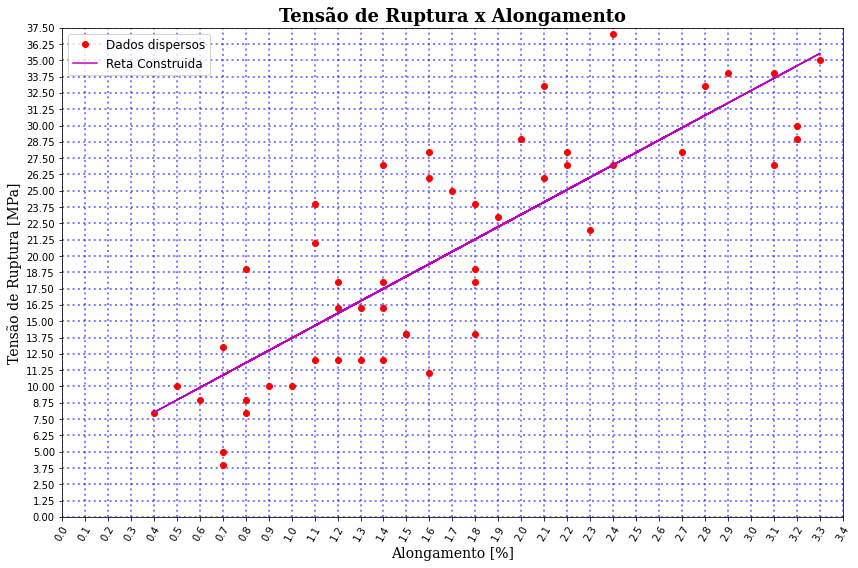

In [53]:
plt.figure(1, figsize=(14,9))
plt.title('Tensão de Ruptura x Alongamento', fontfamily = 'serif', fontsize = 18, fontweight = 'bold')
plt.grid(True, linewidth = 2, linestyle =':', color='b', alpha=0.5)
plt.plot(dados['elongation'],dados['tension_strenght'], 'o', label='Dados dispersos', color='r')
plt.plot(dados['elongation'],regr_ten_def.intercept+(regr_ten_def.slope*dados['elongation']), 
    label = 'Reta Construida', color='m')
plt.legend(fontsize=12,frameon=True)
plt.xlabel('Alongamento [%]',fontsize=14,fontfamily='serif')
plt.ylabel('Tensão de Ruptura [MPa]',fontsize=14,fontfamily='serif')
plt.yticks(np.arange(0,40,1.25))
plt.ylim(0,37.5)
plt.xticks(np.arange(0,3.5,0.1),rotation=60)
plt.xlim(0,3.4)